# Algorithm Comparison

In [ ]:
import numpy as np
import arviz
import matplotlib.pyplot as plt
from utils import plotting
import mhn
from mhn.mcmc.mcmc import MCMC
from mhn.mcmc.kernels import RWMKernel, MALAKernel, smMALAKernel
import time

import sys
sys.path.append("..")
from mcmc_sampling.utils import sym_l2

burn_in = 0.2

In [ ]:
data = np.loadtxt(f"../data/G13_LUAD_12.csv", delimiter=",", skiprows=1,
                  usecols=range(1, 13), dtype=np.int32)
mhn_model = mhn.model.oMHN.load(
    f"../results/mhns/G13_LUAD_12_sym-l2_mle.csv")

speed = dict()

for algo_name, kernel in [
                          ("smMALA", smMALAKernel),
    ("RWM", RWMKernel),
                          ("MALA", MALAKernel),
                          ]:
    mcmc_sampler = MCMC(
        mhn_model=mhn_model,
        data=data,
        penalty=(sym_l2.sym_l2,
                sym_l2.sym_l2_grad,
                sym_l2.sym_l2_hessian),
        kernel_class=kernel,
        step_size=0.0001,
        thin=1,
    )
    n_steps = 10 if algo_name == "smMALA" else 100
    t0 = time.time()
    mcmc_sampler.run(max_steps=n_steps)
    t1 = time.time()
    speed[algo_name] = (t1 - t0)/n_steps
    print(f"{algo_name}:\t {(t1 - t0)/n_steps:.5f} seconds per step")

smMALA:	 1.11117 seconds per step
RWM:	 0.06460 seconds per step
MALA:	 0.06653 seconds per step


In [4]:
samples_rwm = np.load(
    "../results/mcmc/G13_LUAD_12_sym-l2_RWM_0_128125.npy")
samples_mala = np.load(
    "../results/mcmc/G13_LUAD_12_sym-l2_MALA_0_0015625.npy")
samples_smmala = np.load(
    "../results/mcmc/G13_LUAD_12_sym-l2_smMALA_0_029335937500000003.npy")

In [5]:
rhat = dict()
ess = dict()
plot_range = dict()

for algorithm, samples in [("RWM", samples_rwm), ("MALA", samples_mala), ("smMALA", samples_smmala)]:
    step_range = np.linspace(13, 360, 30).astype(int)
    time_range = (step_range.copy() *
                  speed["MALA"] / speed[algorithm]).astype(int)

    plot_range[algorithm] = np.concatenate([step_range, time_range])
    plot_range[algorithm] = np.sort(np.unique(plot_range[algorithm]))

    plot_range[algorithm] = plot_range[algorithm][plot_range[algorithm] >= 13]

    rhat[algorithm] = np.zeros((len(plot_range[algorithm]), samples.shape[-1]))
    ess[algorithm] = np.zeros((len(plot_range[algorithm]), samples.shape[-1]))
    for i, x in enumerate(plot_range[algorithm]):
        inf_data = arviz.convert_to_inference_data(samples[:, int(burn_in * x):x, :])
        rhat[algorithm][i] = arviz.rhat(inf_data).x
        ess[algorithm][i] = arviz.ess(inf_data).x

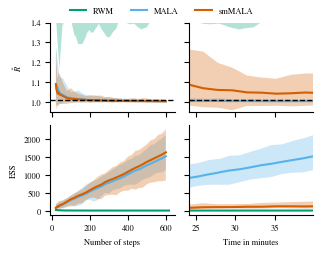

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(3.21, 2.5), sharex="col", sharey="row")
for i in range(2):
    for j in range(2):

        a = ax[i, j]

        for algo_name in rhat.keys():       

            metric = rhat if i == 0 else ess

            a.plot(plot_range[algo_name] * 100 *(speed[algo_name] ** j / 60),
                          metric[algo_name].mean(axis=1), label=algo_name)
            a.fill_between(plot_range[algo_name] * 100 * (speed[algo_name] ** j / 60),
                                  metric[algo_name].min(axis=1), metric[algo_name].max(axis=1), alpha=0.3)
        for spine in ["top", "right"]:
            a.spines[spine].set_visible(False)
        
        if j == 1:
            a.set_xlim(
                min(plot_range["smMALA"] * speed["smMALA"] * 100 / 60),
                max(plot_range["RWM"] * speed["RWM"] * 100 / 60),)
        if i == 0:
            a.set_ylim(0.95, 1.4)
            a.axhline(1.01, color='black', linestyle='--', lw=1)
ax[0,0].set_ylabel("$\hat{R}$")
ax[1,0].set_ylabel("ESS")
ax[1,0].set_xlabel("Number of steps")
ax[1,1].set_xlabel("Time in minutes")

handles, labels = ax[0,0].get_legend_handles_labels()

legend = fig.legend(handles, labels, loc="upper center", ncol=3, 
                    )
legend.get_frame().set_edgecolor('white')
fig.tight_layout()
fig.subplots_adjust(top=0.93)

fig.savefig("../results/figs/algorithm_comparison.pdf")

In [6]:
print("max(R hat) for RWM after 1,000,000 steps:", end=' ')
print(float(arviz.rhat(arviz.convert_to_dataset(samples_rwm[:, int(samples_rwm.shape[1] * burn_in):])).x.max()))

print("min(ESS) for RWM after 1,000,000 steps:", end=' ')
print(float(arviz.ess(arviz.convert_to_dataset(samples_rwm[:, int(samples_rwm.shape[1] * burn_in):])).x.min()))

print("min(ESS) for MALA after 36,000 steps:", end=' ')
print(float(arviz.ess(arviz.convert_to_dataset(samples_mala[:, int(360 * burn_in):360])).x.min()))

print("min(ESS) for smMALA after 36,000 steps:", end=' ')
print(float(arviz.ess(arviz.convert_to_dataset(samples_smmala[:, int(360 * burn_in):360])).x.min()))

max(R hat) for RWM after 1,000,000 steps: 3.2198511272497763
min(ESS) for RWM after 1,000,000 steps: 11.135202500134346
min(ESS) for MALA after 36,000 steps: 1135.2441534135596
min(ESS) for smMALA after 36,000 steps: 842.4314928600087
